In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import pickle 
#import mglearn
import time

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

In [3]:
movies = pd.read_csv('wiki_movie_plots_deduped.csv')

In [4]:
movies.head(6)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year        34886 non-null int64
Title               34886 non-null object
Origin/Ethnicity    34886 non-null object
Director            34886 non-null object
Cast                33464 non-null object
Genre               34886 non-null object
Wiki Page           34886 non-null object
Plot                34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [6]:
movies.shape

(34886, 8)

In [7]:
movies.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


In [8]:
movies['Count']=1
movies[['Genre','Count']].groupby(['Genre'], as_index=False).count()

,Genre,Count
0,,28
1,usa,1
2,"usa, can",1
3,-,3
4,16 mm film,1
5,[140],1
6,[144],1
7,action,1098
8,action,21
9,action & comedy,1


In [9]:
# harmonization
movies['GenreCorrected'] =movies['Genre'] 
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' - ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' / ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('/', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' & ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(', ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('; ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-pic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biopic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographical', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biodrama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-drama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(film genre\)', '')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animated','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anime','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('children\'s','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedey','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[not in citation given\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historical','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romantic','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3-d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('viacom 18 motion pictures','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci-fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ttriller','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('.','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('based on radio serial','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' on the early years of hitler','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science fiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (30min)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('16 mm film','short')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[140\]','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[144\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' for ','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventures','adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung-fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial arts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war ii','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war i','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(volleyball\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy film','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anthology film','anthology')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography fim','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('avant-garde','avant_garde')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biker film','biker')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy cop','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy film','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('films','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('film','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('british-german co-production','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bruceploitation','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movie','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming of age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama about child soldiers','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( based).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( co-produced).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( about).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musical b','musical')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationchildren','animation|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' period','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama loosely','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("war-time","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wartime","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("ww1","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wwii","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psychological','psycho')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom-coms','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('true crime','crime')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|007','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('slice of life','slice_of_life')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computer animation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gun fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('j-horror','horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(shogi|chess\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('afghan war drama','war drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|6 separate stories','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(30min\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (road bicycle racing)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' v-cinema','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' in animation','|animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptation).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptated).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( on ).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('american football','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(artistic\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \|direct-to-dvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('history dram','history drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial art','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = movies['GenreCorrected']=="ero"
movies.loc[filterE,'GenreCorrected']="adult"
filterE = movies['GenreCorrected']=="music"
movies.loc[filterE,'GenreCorrected']="musical"
filterE = movies['GenreCorrected']=="-"
movies.loc[filterE,'GenreCorrected']=''
filterE = movies['GenreCorrected']=="comedy–drama"
movies.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = movies['GenreCorrected']=="comedy–horror"
movies.loc[filterE,'GenreCorrected'] = "comedy|horror"
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' ','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(',','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('-','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionadventure','action|adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actioncomedy','action|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actiondrama','action|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionlove','action|love')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionmasala','action|masala')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionchildren','action|children')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedydrama','comedy|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sciencefiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationdrama','animation|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('muslim','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('thriler','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('crimethriller','crime|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantay','fantasy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionthriller','action|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedysocial','comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martialarts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('epichistory','epic|history')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotica','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotic','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((\|produced\|).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('chanbara','chambara')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|directtodvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('liveaction','live|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('melodrama','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroes','superheroe')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heistcomedy','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heist','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historic','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historydisaster','history|disaster')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('warcomedy','war|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('westerncomedy','western|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ancientcostume','costume')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computeranimation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramatic','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramaa','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('famil\|','family')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroe','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biogtaphy','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('docufiction','documentary|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familydrama','family|drama')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('espionage','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('supeheroes','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancefiction','romance|fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musicaliography','musical|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('triller','thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanceaction','romance|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancehorror','romance|horror')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romcom','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom\|com','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('satirical','satire')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('homosexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexual','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mockumentary','documentary')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('periodic','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanctic','romantic')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('politics','political')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('samurai','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv_miniseries','series')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('serial','series')



In [11]:
filterE = movies['GenreCorrected']=="musical–comedy"
movies.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = movies['GenreCorrected']=="roman|porno"
movies.loc[filterE,'GenreCorrected'] = "adult"


filterE = movies['GenreCorrected']=="action—masala"
movies.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = movies['GenreCorrected']=="horror–thriller"
movies.loc[filterE,'GenreCorrected'] = "horror|thriller"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('family','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial_arts','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horror','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('war','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventure','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fiction','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('noir','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superhero','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('social','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspense','action')


filterE = movies['GenreCorrected']=="drama|romance|adult|children"
movies.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|–\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip(to_strip='\|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionner','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()


In [12]:
moviesGenre = movies[['GenreCorrected','Count']].groupby(['GenreCorrected']).count()
moviesGenre.to_csv('GenreCorrected.csv',sep=',')

In [13]:
moviesGenre

,Count
GenreCorrected,
,6206
action,3790
action|action,163
action|action|action,21
action|action|action|comedy|action,1
action|action|action|drama,1
action|action|action|fantasy|action,1
action|action|action|fantasy|action|comedy,1
action|action|action|fantasy|drama|action,1


In [14]:
movies[['GenreCorrected','Count']].groupby(['GenreCorrected'], as_index=False).count().shape[0]

1198

In [15]:
movies[['GenreCorrected','Count']].groupby(['GenreCorrected'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)

,GenreCorrected,Count
0,,6206
515,drama,6107
358,comedy,4411
1,action,3790
1110,thriller,2163
963,romance,954
202,animation,601
972,romance|comedy,577
446,crime,573
386,comedy|drama,560


In [16]:
movies['GenreSplit']=movies['GenreCorrected'].str.split('|')
movies['GenreSplit']= movies['GenreSplit'].apply(np.sort).apply(np.unique)

In [17]:
movies

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,GenreCorrected,GenreSplit
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",1,,[]
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",1,,[]
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",1,,[]
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,1,,[]
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,1,,[]
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",1,,[]
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,1,action,[action]
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,comedy,[comedy]
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...,1,,[]
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....,1,,[]


In [18]:
movies['GenreSplit'][11]

array(['action', 'crime', 'short'], dtype='<U6')

In [19]:
genres_array = np.array([])

for i in range(0,movies.shape[0]-1):
    genres_array = np.concatenate((genres_array, movies['GenreSplit'][i] ))

In [20]:
genres_array

array(['', '', '', ..., 'comedy', 'comedy', 'romance'], dtype='<U32')

In [21]:
genres = pd.DataFrame({'Genre':genres_array})

In [22]:
genres

,Genre
0,
1,
2,
3,
4,
5,
6,action
7,comedy
8,
9,


In [23]:
# histogram for the genres is most welcome
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)\
.head(10)# histogram for the genres is most welcome

,Genre,Count
115,drama,9487
84,comedy,7320
0,,6222
3,action,5952
425,thriller,3291
336,romance,2639
93,crime,1607
243,musical,951
15,animation,914
72,children,684


In [24]:
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)

In [25]:
genres = genres[genres['Genre']!='']
genres.head(25)

,Genre,Count
115,drama,9487
84,comedy,7320
3,action,5952
425,thriller,3291
336,romance,2639
93,crime,1607
243,musical,951
15,animation,914
72,children,684
130,fantasy,542


In [26]:
TotalCountGenres=sum(genres['Count'])

In [27]:
genres['Frequency'] = genres['Count']/TotalCountGenres

In [28]:
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()

In [29]:
genres.head(20)

,Genre,Count,Frequency,CumulativeFrequency
115,drama,9487,0.254200,0.254200
84,comedy,7320,0.196136,0.450336
3,action,5952,0.159481,0.609818
425,thriller,3291,0.088181,0.697998
336,romance,2639,0.070711,0.768709
93,crime,1607,0.043059,0.811768
243,musical,951,0.025482,0.837250
15,animation,914,0.024490,0.861740
72,children,684,0.018327,0.880068
130,fantasy,542,0.014523,0.894590


In [30]:
np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political'], dtype=object)

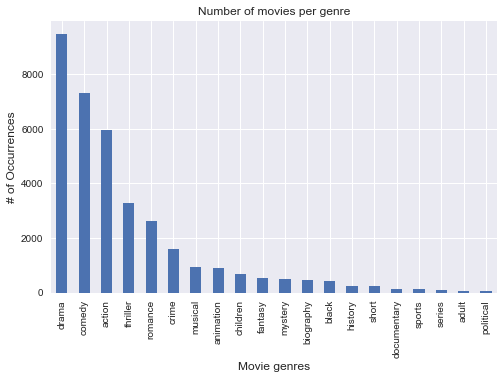

In [31]:
genres[genres['CumulativeFrequency']<=.957][['Genre','Count']].plot(x='Genre', y='Count', kind='bar'\
                                                                    , legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [32]:
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])

In [33]:
arr1=np.array(['adult', 'romance', 'drama','and'])
arr1[np.in1d(arr1,mainGenres)] # genres not in the mainGenres array will be deleted

array(['adult', 'romance', 'drama'], dtype='<U7')

In [34]:
movies['GenreSplit'][10:12].apply(lambda x: x[np.in1d(x,mainGenres)])

10                   [short]
11    [action, crime, short]
Name: GenreSplit, dtype: object

In [35]:
movies['GenreSplitMain'] = movies['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])

In [36]:
movies[['GenreSplitMain','GenreSplit','Genre']][200:220]

,GenreSplitMain,GenreSplit,Genre
200,[drama],[drama],drama
201,[drama],[drama],drama
202,[comedy],[comedy],comedy
203,[drama],[drama],drama
204,[comedy],[comedy],comedy
205,"[comedy, drama]","[comedy, drama]",comedy drama
206,[mystery],[mystery],mystery
207,[drama],[drama],drama
208,[drama],[drama],drama
209,"[comedy, drama]","[comedy, drama]",comedy drama


In [37]:
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [38]:
list(movies['Plot'][10:12].apply(clean_text))

['the rarebit fiend gorges on welsh rarebit at a restaurant. when he leaves, he begins to get dizzy as he starts to hallucinate. he desperately tries to hang onto a lamppost as the world spins all around him. a man helps him get home. he falls into bed and begins having more hallucinatory dreams. during a dream sequence, the furniture begins moving around the room. imps emerge from a floating welsh rarebit container and begin poking his head as he sleeps. his bed then begins dancing and spinning wildly around the room before flying out the window with the fiend in it. the bed floats across the city as the fiend floats up and off the bed. he hangs off the back and eventually gets caught on a weathervane atop a steeple. his bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. the fiend awakens from the dream after falling out of his bed.',
 'the film features a train traveling through the rockies and a hold up created by two thugs placing logs on the line. the

In [39]:
list(movies['Plot'][10:12])

['The Rarebit Fiend gorges on Welsh rarebit at a restaurant. When he leaves, he begins to get dizzy as he starts to hallucinate. He desperately tries to hang onto a lamppost as the world spins all around him. A man helps him get home. He falls into bed and begins having more hallucinatory dreams. During a dream sequence, the furniture begins moving around the room. Imps emerge from a floating Welsh rarebit container and begin poking his head as he sleeps. His bed then begins dancing and spinning wildly around the room before flying out the window with the Fiend in it. The bed floats across the city as the Fiend floats up and off the bed. He hangs off the back and eventually gets caught on a weathervane atop a steeple. His bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. The Fiend awakens from the dream after falling out of his bed.',
 'The film features a train traveling through the Rockies and a hold up created by two thugs placing logs on the line. The

In [40]:
movies['PlotClean'] = movies['Plot'].apply(clean_text)

In [41]:
movies[['Plot','PlotClean','GenreSplitMain']][6:12]

,Plot,PlotClean,GenreSplitMain
6,The film opens with two bandits breaking into ...,the film opens with two bandits breaking into ...,[action]
7,The film is about a family who move to the sub...,the film is about a family who move to the sub...,[comedy]
8,The opening scene shows the interior of the ro...,the opening scene shows the interior of the ro...,[]
9,Scenes are introduced using lines of the poem....,scenes are introduced using lines of the poem....,[]
10,The Rarebit Fiend gorges on Welsh rarebit at a...,the rarebit fiend gorges on welsh rarebit at a...,[short]
11,The film features a train traveling through th...,the film features a train traveling through th...,"[action, crime, short]"


In [42]:
len(movies['GenreSplitMain'][0])

0

In [43]:
movies['GenreSplitMain'][0:5].apply(len)

0    0
1    0
2    0
3    0
4    0
Name: GenreSplitMain, dtype: int64

In [44]:
movies['MainGenresCount'] = movies['GenreSplitMain'].apply(len)

In [45]:
max(movies['MainGenresCount'] )

7

In [46]:
movies[movies['MainGenresCount']==7]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,GenreCorrected,GenreSplit,GenreSplitMain,PlotClean,MainGenresCount
17314,2017,American Made,American,Doug Liman,Doug Liman (director); Gary Spinelli (screenpl...,"biography, action, comedy, crime, drama, histo...",https://en.wikipedia.org/wiki/American_Made_(f...,"In the late 1970s, Barry Seal, a pilot for com...",1,biography|action|comedy|crime|drama|history|th...,"[action, biography, comedy, crime, drama, hist...","[action, biography, comedy, crime, drama, hist...","in the late 1970s, barry seal, a pilot for com...",7


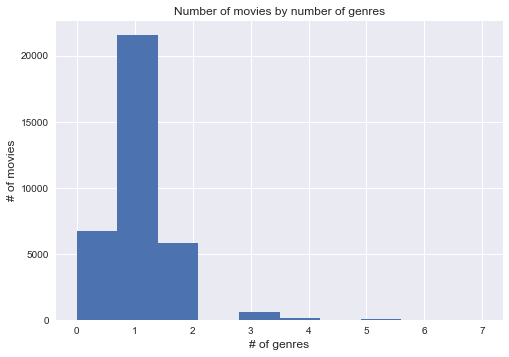

In [47]:
movies['MainGenresCount'].hist()

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

In [48]:
txt = ["He is ::having a great Time, at the park time?",
       "She, unlike most women, is a big player on the park's grass.",
       "she can't be going"]

In [49]:
# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [50]:
# Transforms the data into a bag of words
count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

# Print the first 10 features of the count_vec
print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['big', 'going', 'grass', 'great', 'having', 'park', 'player', 'time', 'unlike', 'women']

Every 3rd feature:
['big', 'great', 'player', 'women']


In [51]:
count_vec.fit_transform(txt).toarray()

array([[0, 0, 0, 1, 1, 1, 0, 2, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [52]:
count_vec.get_feature_names()[:3]

['big', 'going', 'grass']

In [53]:
#z = movies.GenreSplitMain.str.split()
movies.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2
6,action,None,None
7,comedy,None,None
8,,None,None
9,,None,None
10,short,None,None
11,action,crime,short
12,short,None,None
13,biography,None,None
14,comedy,None,None


In [54]:
movies.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,action,biography,comedy,crime,short
6,1,0,0,0,0
7,0,0,1,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,1
11,1,0,0,1,1
12,0,0,0,0,1
13,0,1,0,0,0
14,0,0,1,0,0


In [55]:
movies.GenreSplitMain[6:15]

6                   [action]
7                   [comedy]
8                         []
9                         []
10                   [short]
11    [action, crime, short]
12                   [short]
13               [biography]
14                  [comedy]
Name: GenreSplitMain, dtype: object

In [56]:
movies.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Count', 'GenreCorrected', 'GenreSplit',
       'GenreSplitMain', 'PlotClean', 'MainGenresCount'],
      dtype='object')

In [57]:
movies.shape

(34886, 14)

In [58]:
len(movies.Title.unique()) # the title is not unique

32432

In [59]:
movies[movies.GenreCorrected==''].shape

(6206, 14)

In [60]:
# the dummy classes
movies = pd.concat([movies, movies.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [61]:
movies.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,GenreCorrected,...,fantasy,history,musical,mystery,political,romance,series,short,sports,thriller
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",1,,...,0,0,0,0,0,0,0,0,0,0
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",1,,...,0,0,0,0,0,0,0,0,0,0
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",1,,...,0,0,0,0,0,0,0,0,0,0
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,1,,...,0,0,0,0,0,0,0,0,0,0
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,1,,...,0,0,0,0,0,0,0,0,0,0
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",1,,...,0,0,0,0,0,0,0,0,0,0
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,1,action,...,0,0,0,0,0,0,0,0,0,0
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,comedy,...,0,0,0,0,0,0,0,0,0,0
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...,1,,...,0,0,0,0,0,0,0,0,0,0
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....,1,,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# the train and the test data set will be build when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(movies[movies.GenreCorrected!=''], random_state=42, test_size=0.30, shuffle=True)

In [63]:
# definition the algorithm for feature extraction
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [64]:
# building the features
x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
x_test  = tfidf.transform(MoviesTest.PlotClean)
### for test data, the feature extraction will be done through the function transform()
### to make sure there is no features dimensionality mismatch

In [65]:
print('nrow of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))

nrow of the MoviesTrain =20076


In [66]:
print('nrow of the MoviesTest ={}'. format(MoviesTest.shape[0]))

nrow of the MoviesTest =8604


In [80]:
movies.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Count', 'GenreCorrected', 'GenreSplit',
       'GenreSplitMain', 'PlotClean', 'MainGenresCount', 'action', 'adult',
       'animation', 'biography', 'black', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'history', 'musical', 'mystery',
       'political', 'romance', 'series', 'short', 'sports', 'thriller'],
      dtype='object')

In [81]:
movies.PlotClean

0        a bartender is working at a saloon, serving dr...
1        the moon, painted with a smiling face hangs ov...
2        the film, just over a minute long, is composed...
3        lasting just 61 seconds and consisting of two ...
4        the earliest known adaptation of the classic f...
5        alice follows a large white rabbit down a "rab...
6        the film opens with two bandits breaking into ...
7        the film is about a family who move to the sub...
8        the opening scene shows the interior of the ro...
9        scenes are introduced using lines of the poem....
10       the rarebit fiend gorges on welsh rarebit at a...
11       the film features a train traveling through th...
12       irish villager kathleen is a tenant of captain...
13       boone  daughter befriends an indian maiden as ...
14       before heading out to a baseball game at a nea...
15       the plot is that of a black woman going to the...
16       on a beautiful summer day a father and mother .

In [67]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [68]:
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['1930s', '1937', 'abilities', 'able', 'accept', 'accepts',
        'acquaintance', 'actively', 'adversely', 'affects', 'aggressive',
        'agrees', 'aide', 'allow', 'amidst', 'apartment', 'arena', 'army',
        'arouses', 'arrives', 'artist', 'artists', 'arts', 'attempts',
        'away', 'bag', 'bandit', 'bandits', 'barely', 'barrage', 'battle',
        'beaten', 'beating', 'beats', 'blows', 'bruce', 'brutal',
        'challenge', 'challenges', 'chance', 'chaos', 'cheered', 'child',
        'chinese', 'ching', 'chow', 'chuen', 'chun', 'claimed', 'closed',
        'coal', 'colleagues', 'collect', 'colonel', 'come', 'compete',
        'competitions', 'consents', 'conserve', 'contain', 'cotton',
        'crowd', 'days', 'declines', 'decrepit', 'defeat', 'defeats',
        'defends', 'defense', 'demands', 'desperate', 'despite', 'direct',
        'disciples', 'discussing', 'displays', 'does', 'door', 'earlier',
        'earn', 'effective', 'embarrassing', 'energy', 'enhanced'

In [70]:
print('The corpus is huge. It contain {} words.'.format(len(x_train[0].toarray()[0])))

The corpus is huge. It contain 103411 words.


In [71]:
# building the classes
y_train = MoviesTrain[MoviesTrain.columns[14:]]
y_test = MoviesTest[MoviesTest.columns[14:]]

In [72]:
len(y_train.columns)

20

In [73]:
len(y_test.columns)

20

In [74]:
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [75]:
# fitting
multinomialNB.fit(x_train, y_train.action)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

In [76]:
# compute the testing accuracy
prediction = multinomialNB.predict(x_test)

In [77]:
print('Test accuracy is {}'.format(accuracy_score(y_test.action, prediction)))

Test accuracy is 0.8265922826592282


In [79]:
x_test

<8604x103411 sparse matrix of type '<class 'numpy.float64'>'
	with 1183544 stored elements in Compressed Sparse Row format>